In [1]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

--2024-02-22 15:35:11--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2024-02-22 15:35:11--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  45.3MB/s    in 0.2s    

2024-02-22 15:35:12 (45.3 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

In [2]:
! pip install scanpy
! pip install scrublet

import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as sl
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation

  Using cached scanpy-1.9.8-py3-none-any.whl (2.0 MB)
  Using cached anndata-0.10.5.post1-py3-none-any.whl (121 kB)
  Using cached natsort-8.4.0-py3-none-any.whl (38 kB)
  Using cached numba-0.59.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached session_info-1.0.0-py3-none-any.whl
  Using cached umap_learn-0.5.5-py3-none-any.whl
  Using cached array_api_compat-1.4.1-py3-none-any.whl (30 kB)
  Using cached llvmlite-0.42.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.8 MB)
  Using cached pynndescent-0.5.11-py3-none-any.whl (55 kB)
  Using cached stdlib_list-0.10.0-py3-none-any.whl (79 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
  Using cached scrublet-0.2.3-py3-none-any.whl (15 kB)
  Using cached annoy-1.17.3-cp310-cp310-linux_x86_64.whl


In [3]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [4]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

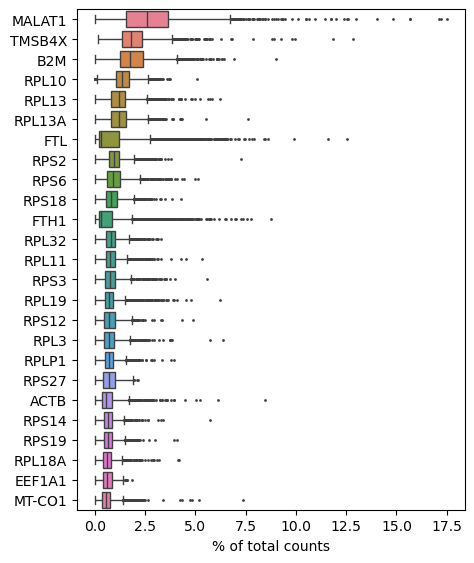

In [7]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=25, )

In [8]:
sc.external.pp.scrublet(adata)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.30
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 35.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.7%


In [9]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'doublet_score', 'predicted_doublet'
    var: 'gene_ids'
    uns: 'scrublet'

In [10]:
adata.uns

OrderedDict([('scrublet',
              {'doublet_scores_sim': array([0.02967564, 0.40314136, 0.06487696, ..., 0.05182342, 0.08310992,
                      0.11036789]),
               'doublet_parents': array([[2607, 1653],
                      [ 835,  763],
                      [1731, 1033],
                      ...,
                      [1693, 2273],
                      [1551, 2149],
                      [ 341, 1619]]),
               'parameters': {'expected_doublet_rate': 0.05,
                'sim_doublet_ratio': 2.0,
                'n_neighbors': 26,
                'random_state': 0},
               'threshold': 0.30128205128205165})])

In [11]:
adata.obs.predicted_doublet.value_counts()

predicted_doublet
False    2665
True       35
Name: count, dtype: int64

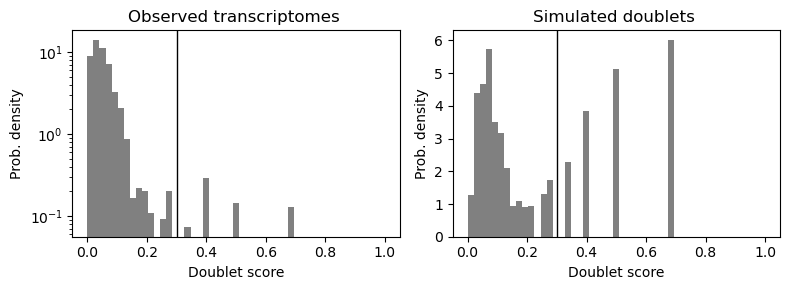

In [12]:
# Plot histogram of doublet scores for observed transcriptomes and simulated doublets.                                                                       
# The histogram for simulated doublets is useful for determining the correct doublet score threshold.                                                                                                                                        
sc.external.pl.scrublet_score_distribution(adata)

In [13]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-") # annotate the group of mitochondrial genes as 'mt'
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL")) # annotate the group of ribosomal genes as 'ribo'

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[25], log1p=True
)
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_25_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'

In [14]:
# def is-outlier sc best practices
# function that takes a metric, i.e. a column in .obs and the number of MADs (nmad) that is still permissive within the filtering strategy
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [15]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_25_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    2606
True       94
Name: count, dtype: int64

In [16]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    2488
True      212
Name: count, dtype: int64

In [19]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 2423
Number of cells after filtering of low quality cells: 2423


In [20]:
# Saving count data
adata.layers["raw_counts"] = adata.X.copy()

In [21]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# log1p transform
sc.pp.log1p(adata)

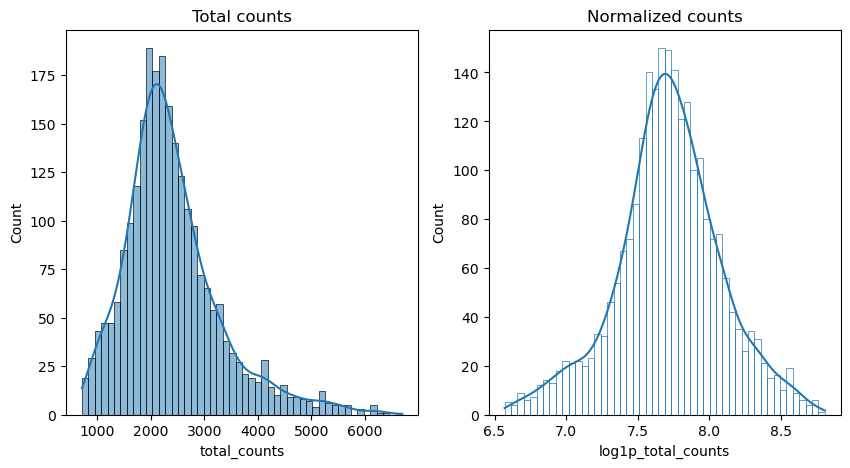

In [22]:
# Plot counts distribution before and after Normalization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=50, kde=True, fill=True, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.obs["log1p_total_counts"], bins=50, kde=True, fill=False, ax=axes[1])
axes[1].set_title("Normalized counts")
plt.show()

In [23]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [24]:
! pip install plotly
import plotly as py
import plotly.express as px

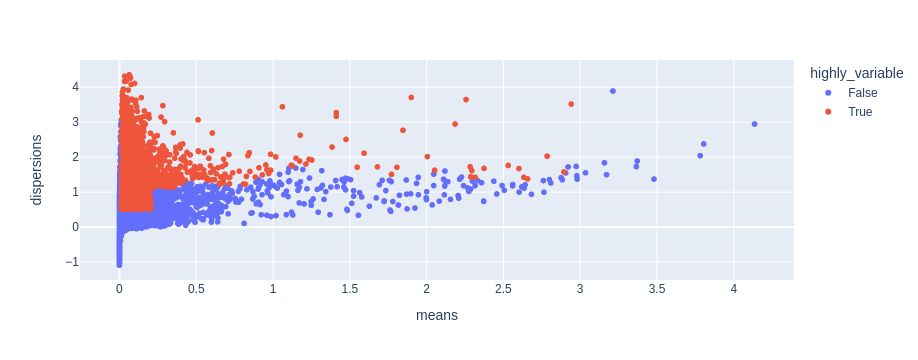

In [25]:
fig = px.scatter(adata.var, x="means", y="dispersions", color="highly_variable", hover_data=['gene_ids'])
fig.show()